#Frequency Modulation

In [1]:
!pip install sounddevice soundfile numpy matplotlib

In [2]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from scipy.io.wavfile import write
from scipy import signal as sg
from IPython.display import Audio
from scipy.signal import hilbert

In [3]:
def plot_wav(filename):

    data, fs = sf.read(filename)
    print(f"✅ Loaded '{filename}'")
    print(f"Sampling rate: {fs} Hz")
    print(f"Duration: {len(data)/fs:.2f} seconds")
    time = np.linspace(0, len(data) / fs, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, color='blue')
    plt.title(f"Waveform of {filename}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
signal, fs = sf.read("/content/dc2.wav")
signal = signal.flatten()

✅ Loaded '/content/dc2.wav'
Sampling rate: 48000 Hz
Duration: 5.16 seconds


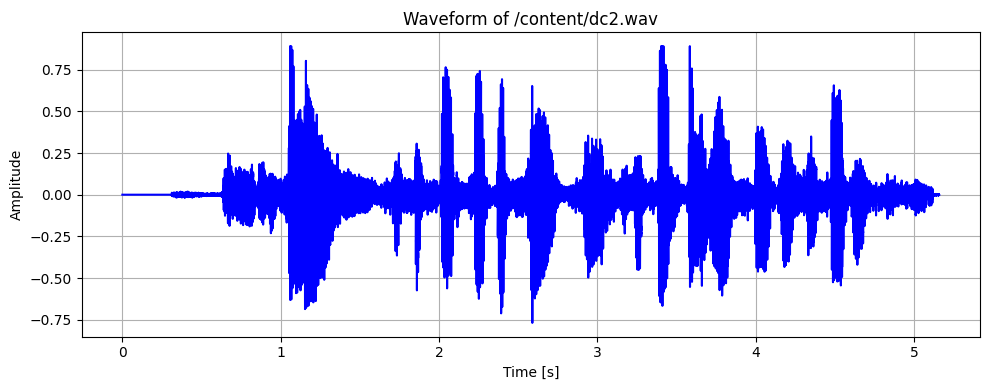

🎧 Playing audio


In [5]:
plot_wav("/content/dc2.wav")
print(f"🎧 Playing audio")
Audio(signal, rate=fs)

In [6]:
# Peak amplitude
peak_amplitude = np.max(np.abs(signal))
print(f"🔊 Peak Amplitude: {peak_amplitude:.3f} V")

🔊 Peak Amplitude: 0.891 V


In [7]:
"""Compute FFT, plot spectrum, and return the peak frequency."""
def analyze_fft(signal, fs):

    n = len(signal)
    fft_data = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=1/fs)

    # Keep only positive frequencies
    mask = freq >= 0
    freq = freq[mask]
    magnitude = np.abs(fft_data[mask])

    # Find peak frequency
    peak_freq = freq[np.argmax(magnitude)]
    print(f"🎵 Peak Frequency: {peak_freq:.2f} Hz")

    # Plot frequency spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(freq, magnitude, color='purple')
    plt.title("Frequency Spectrum (FFT)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return peak_freq

🎵 Peak Frequency: 140.31 Hz


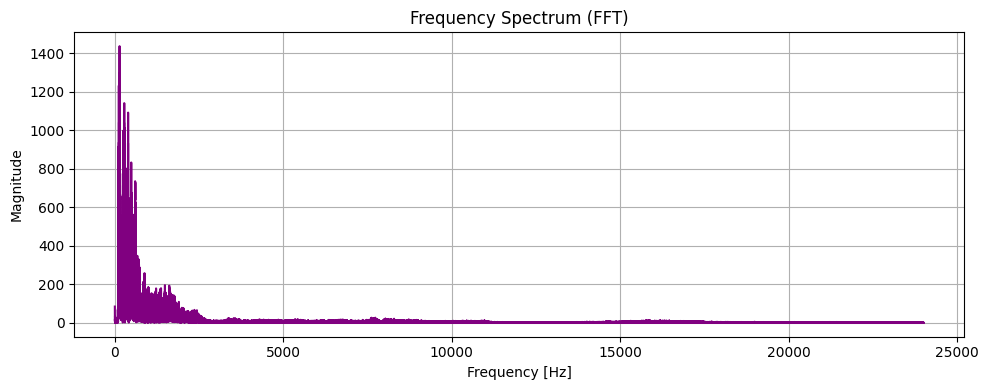

In [8]:
peak_freq = analyze_fft(signal, fs)

In [9]:
"""Wideband FM of message signal."""

def _ensure_mono(signal):

    if signal.ndim > 1:
        return signal.mean(axis=1)
    return signal


def wb_fm_modulate(message, fs, fc=10000, dev=5000, upsample=True):

    # Ensure mono and float
    m = _ensure_mono(message).astype(float)

    # Normalize message to [-1, 1] (keeps dev interpretation consistent)
    max_abs = np.max(np.abs(m))
    if max_abs > 0:
        m = m / max_abs

    # Check for potential aliasing; if fc+dev >= fs/2, we need a higher sampling rate
    nyquist = fs / 2
    required_band = fc + dev
    out_fs = fs
    if upsample and required_band >= nyquist:
        # choose new fs at least 2*(fc+dev) + margin
        out_fs = int(np.ceil(2 * required_band + 2000))  # extra margin 2 kHz
        up_factor = out_fs / fs
        print(f"⚠️ Upsampling from {fs} Hz -> {out_fs} Hz to avoid aliasing (fc+dev = {required_band} Hz).")
        # Resample message to out_fs using FFT resampling
        num_samples = int(np.round(len(m) * up_factor))
        m = sg.resample(m, num_samples)
    else:
        if required_band >= nyquist:
            print(f"⚠️ Warning: fc+dev ({required_band} Hz) >= Nyquist ({nyquist} Hz). Set upsample=True or lower fc/dev.")

    # Time axis for the (possibly resampled) message
    n = len(m)
    t = np.arange(n) / out_fs

    # Integrate message: integral_m(t) ≈ cumulative sum / fs
    # Using simple cumulative sum (area per sample = 1/out_fs)
    integral_m = np.cumsum(m) / out_fs

    # Instantaneous phase = 2π fc t + 2π dev * integral(m)
    phase = 2 * np.pi * fc * t + 2 * np.pi * dev * integral_m

    # FM modulated signal (real, cosine)
    mod_signal = np.cos(phase)

    return mod_signal, out_fs

def plot_waveform(time, data, title="Waveform", zoom_t=None):
    plt.figure(figsize=(10, 3))
    plt.plot(time, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    if zoom_t:
        plt.xlim(0, zoom_t)
    plt.tight_layout()
    plt.show()

def plot_spectrum(signal, fs, title="Frequency Spectrum (FFT)", fmax=None):
    n = len(signal)
    # Use window to reduce leakage
    window = np.hanning(n)
    fft_data = np.fft.rfft(signal * window)
    freq = np.fft.rfftfreq(n, d=1/fs)
    magnitude = np.abs(fft_data) / (n/2)

    plt.figure(figsize=(10, 3))
    if fmax is None:
        plt.plot(freq, magnitude)
    else:
        idx = freq <= fmax
        plt.plot(freq[idx], magnitude[idx])
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(signal, fs, nperseg=1024, noverlap=None, title="Spectrogram"):
    if noverlap is None:
        noverlap = nperseg // 2
    f, t, Sxx = sg.spectrogram(signal, fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='spectrum', mode='magnitude')
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, 20*np.log10(Sxx + 1e-12), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(title)
    plt.colorbar(label='Magnitude (dB)')
    plt.ylim(0, fs/2)
    plt.tight_layout()
    plt.show()

Modulated signal length: 247680 samples, sampling rate: 48000 Hz


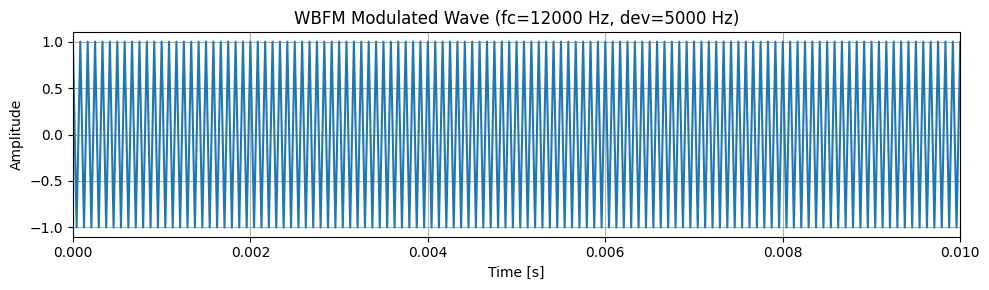

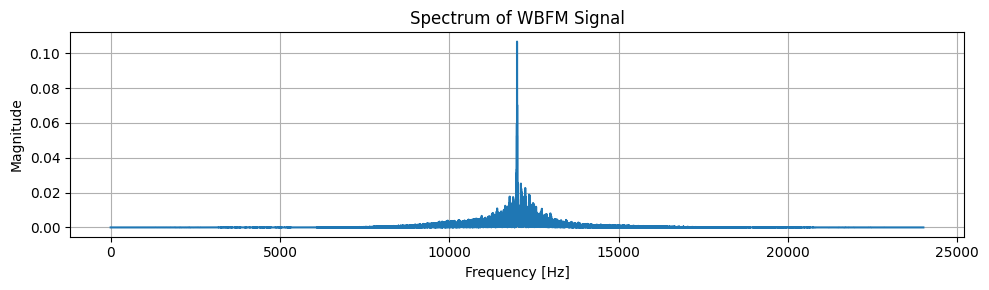

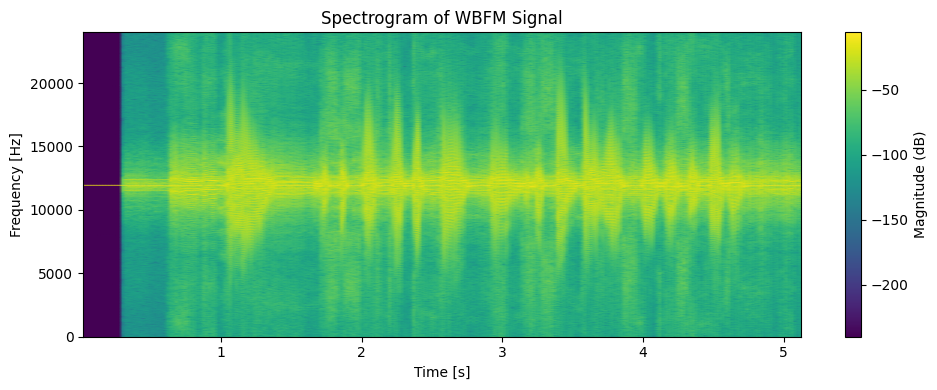

Playing modulated signal


In [10]:
fc = 12000      # carrier frequency in Hz
dev = 5000      # frequency deviation in Hz
upsample = True

mono_signal = _ensure_mono(signal)
mod_sig, mod_fs = wb_fm_modulate(mono_signal, fs, fc=fc, dev=dev, upsample=upsample)
print(f"Modulated signal length: {len(mod_sig)} samples, sampling rate: {mod_fs} Hz")

t_mod = np.arange(len(mod_sig)) / mod_fs
plot_waveform(t_mod, mod_sig, title=f"WBFM Modulated Wave (fc={fc} Hz, dev={dev} Hz)", zoom_t=0.01)
plot_spectrum(mod_sig, mod_fs, title="Spectrum of WBFM Signal", fmax=mod_fs/2)
plot_spectrogram(mod_sig, mod_fs, nperseg=2048, title="Spectrogram of WBFM Signal")

print("Playing modulated signal")
Audio(mod_sig, rate=mod_fs)

In [11]:
"""Adding AWGN to the WBFM signal."""

def add_awgn(signal, snr_db):

    # Compute signal power and required noise power for given SNR
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))

    # Add noise to signal
    noisy_signal = signal + noise

    print(f"✅ Added AWGN: SNR = {snr_db} dB")
    print(f"Signal Power = {signal_power:.6e}, Noise Power = {noise_power:.6e}")
    return noisy_signal


def plot_noisy_signal(original, noisy, fs, title="Noisy WBFM Signal", zoom_t=0.01):

    t = np.arange(len(original)) / fs
    plt.figure(figsize=(10, 3))
    plt.plot(t, original, label="Original", alpha=0.7)
    plt.plot(t, noisy, label="Noisy", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.xlim(0, zoom_t)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

✅ Added AWGN: SNR = 15 dB
Signal Power = 5.000004e-01, Noise Power = 1.581140e-02


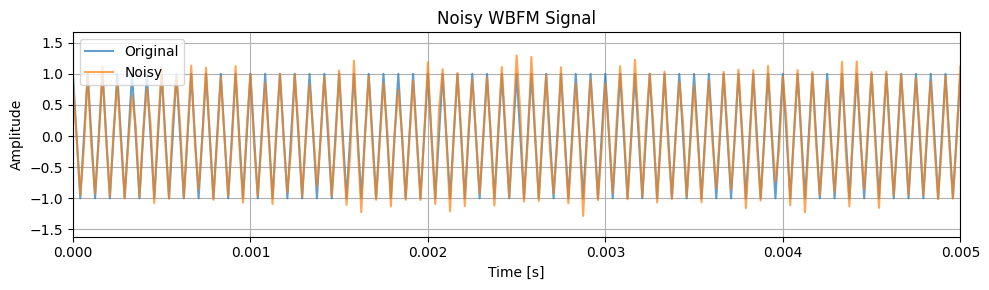

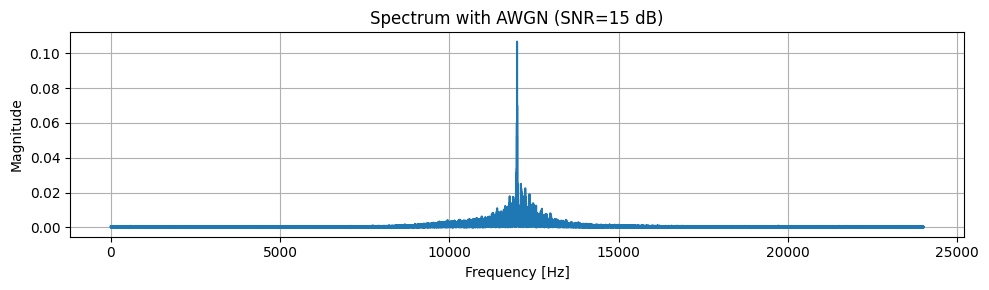

In [12]:
snr_db = 15
noisy_mod_sig = add_awgn(mod_sig, snr_db)
plot_noisy_signal(mod_sig, noisy_mod_sig, mod_fs, zoom_t=0.005)
plot_spectrum(noisy_mod_sig, mod_fs, title=f"Spectrum with AWGN (SNR={snr_db} dB)", fmax=mod_fs/2)

In [13]:
 """Simple FM demodulator using Hilbert transform method."""

def fm_demodulate(fm_signal, fs, fc):

    # Create analytic signal
    analytic_signal = hilbert(fm_signal)

    # Instantaneous phase
    inst_phase = np.unwrap(np.angle(analytic_signal))

    # Instantaneous frequency = derivative of phase / (2π)
    inst_freq = np.diff(inst_phase) * fs / (2.0 * np.pi)

    # Remove carrier frequency offset
    demod = inst_freq - fc

    return demod

def plot_demodulated_comparison(original, demodulated, fs, title="Original vs Demodulated Audio"):

    min_len = min(len(original), len(demodulated))
    original = original[:min_len]
    demodulated = demodulated[:min_len]

    t = np.arange(min_len) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, original / np.max(np.abs(original)), label="Original", alpha=0.8)
    plt.plot(t, demodulated / np.max(np.abs(demodulated)), label="Demodulated", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

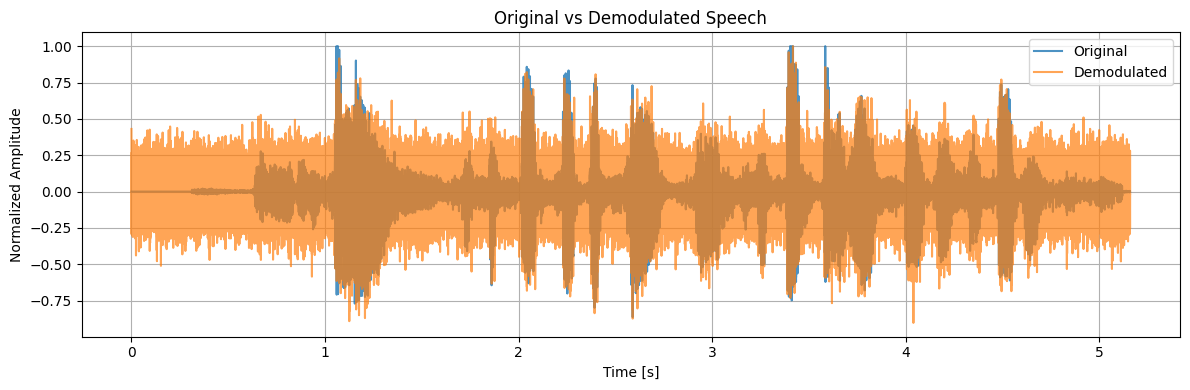

🎧 Playing recovered audio:


In [14]:
demodulated = fm_demodulate(noisy_mod_sig, mod_fs, fc)
plot_demodulated_comparison(signal, demodulated, fs,title="Original vs Demodulated Speech")
print("🎧 Playing recovered audio:")
Audio(demodulated / np.max(np.abs(demodulated)), rate=mod_fs)

In [15]:
def butter_lowpass_filter(data, cutoff, fs, order=6):

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

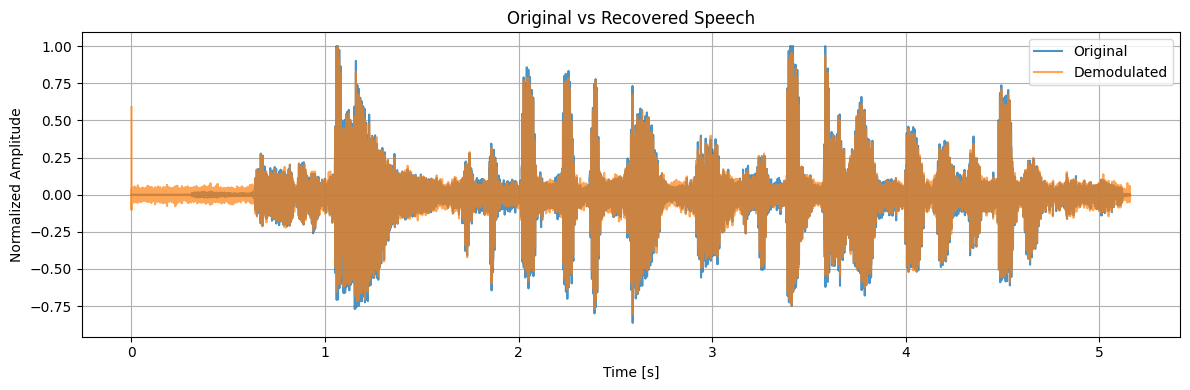

🎧 Playing filtered audio:


In [16]:
cutoff_freq = 3000   # Cutoff frequency in Hz (speech band)
order = 10

clean_audio = butter_lowpass_filter(demodulated, cutoff_freq, mod_fs, order)
plot_demodulated_comparison(signal, clean_audio, fs,title="Original vs Recovered Speech")
print("🎧 Playing filtered audio:")
Audio(clean_audio / np.max(np.abs(clean_audio)), rate=mod_fs)

# Noise Filteration

In [17]:
!pip install librosa soundfile matplotlib numpy scipy ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import butter, lfilter
from IPython.display import Audio, display

In [19]:
DEFAULT_SR = 48000
DEFAULT_FRAME = 1024

In [20]:
def highpass_filter(x, sr, cutoff=80):
    b, a = butter(1, cutoff / (sr / 2), btype='high')
    return lfilter(b, a, x)


# ============================================================
# 🌈 STEP 3: Spectral Noise Reduction
# ============================================================

def spectral_noise_reduction(x, sr, noise_reduction_factor=0.6):
    """Frequency-domain noise gating using STFT."""
    S = librosa.stft(x)
    mag, phase = np.abs(S), np.angle(S)

    # Estimate noise floor
    noise_floor = np.mean(np.sort(mag, axis=1)[:, :10], axis=1, keepdims=True)
    mag_clean = np.maximum(mag - noise_reduction_factor * noise_floor, 0)

    # Reconstruct cleaned signal
    S_clean = mag_clean * np.exp(1j * phase)
    y_clean = librosa.istft(S_clean)

    # Normalize
    y_clean = y_clean / np.max(np.abs(y_clean) + 1e-6)
    return y_clean

def noise_gate(x, threshold=0.02):
    gain = np.where(np.abs(x) < threshold, 0, 1)
    return x * gain

def compressor(x, threshold=0.2, ratio=3.0):
    y = np.copy(x)
    over = np.abs(x) > threshold
    y[over] = np.sign(x[over]) * (threshold + (np.abs(x[over]) - threshold) / ratio)
    return y

def process_offline(y, sr):

    y = highpass_filter(y, sr)
    y = noise_gate(y)
    y = compressor(y)
    y = spectral_noise_reduction(y, sr, noise_reduction_factor=0.6)
    return 0.8 * y


def plot_waveforms(original, denoised, sr):

    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sr, color='gray')
    plt.title("Original Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(denoised, sr=sr, color='green')
    plt.title("Denoised Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")


def compare_spectrograms(original, denoised, sr):

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plot_spectrogram(original, sr, "Original Spectrogram")
    plt.subplot(1, 2, 2)
    plot_spectrogram(denoised, sr, "Denoised Spectrogram")
    plt.tight_layout()
    plt.show()

def play_audio(y, sr, label="Audio"):
    print(f"▶️ {label}")
    display(Audio(y, rate=sr))

In [21]:
def noise_reduction_pipeline(file_path):

    y= clean_audio
    sr= mod_fs
    y_hp = highpass_filter(y, sr, cutoff=50)
    y_denoised = process_offline(y, sr)

    plot_waveforms(y, y_denoised, sr)
    compare_spectrograms(y, y_denoised, sr)
    return y_denoised, sr
    return y_denoised, sr

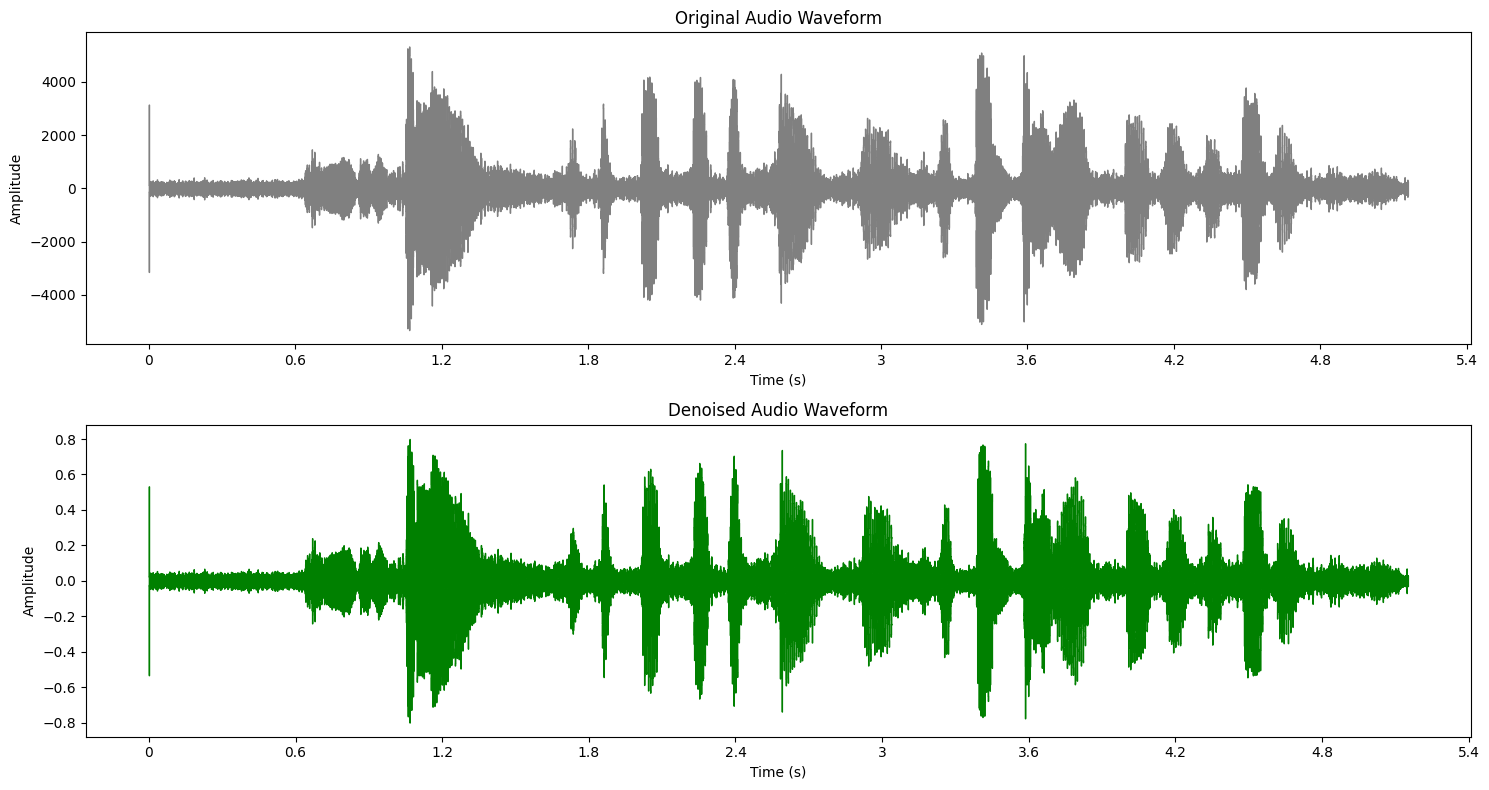

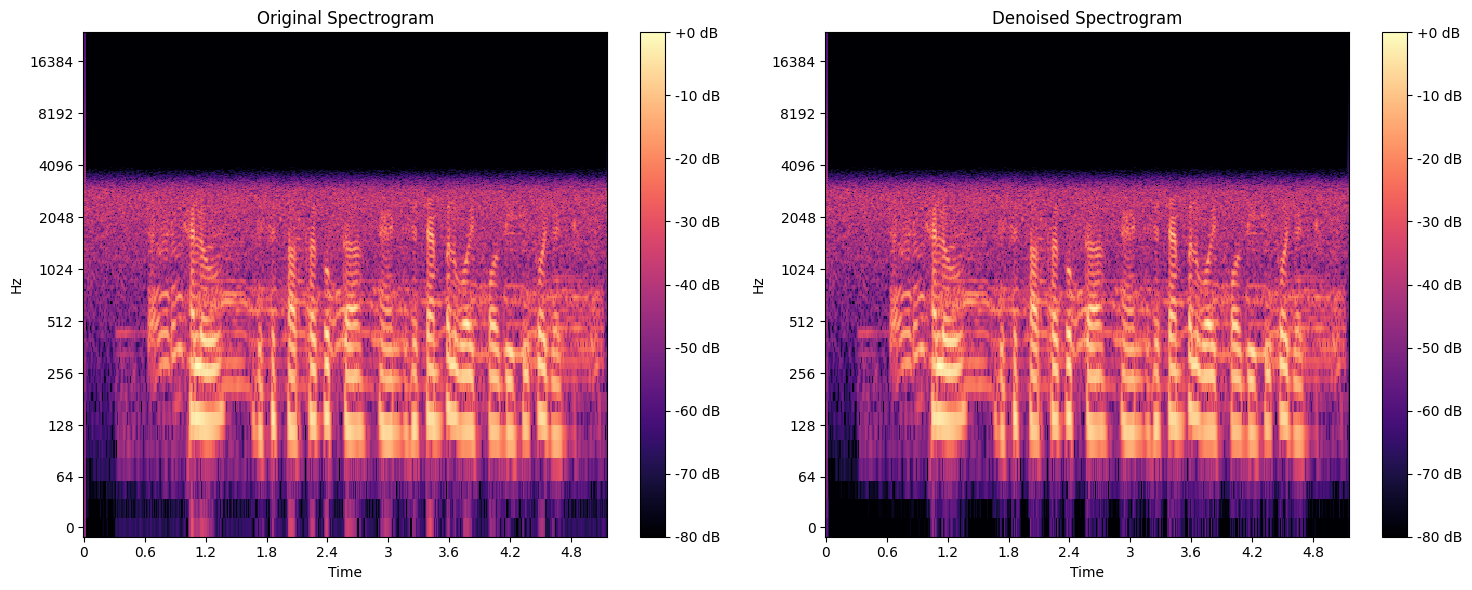

▶️ Demodulated Audio


▶️ Denoised Audio


In [22]:
y= clean_audio
y_denoised, sr = noise_reduction_pipeline(clean_audio)
play_audio(clean_audio, sr, "Demodulated Audio")
play_audio(y_denoised, sr, "Denoised Audio")

In [23]:
!apt-get update -qq
!apt-get install -y autoconf automake libtool libsndfile1-dev ffmpeg > /dev/null

# Clone and build RNNoise
!git clone https://github.com/xiph/rnnoise.git > /dev/null
!cd rnnoise && ./autogen.sh && ./configure && make > /dev/null

!pip install soundfile librosa matplotlib ipywidgets --quiet

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into 'rnnoise'...
remote: Enumerating objects: 907, done.
remote: Counting objects: 100% (426/426), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 907 (delta 383), reused 349 (delta 349), pack-reused 481 (from 2)
Receiving objects: 100% (907/907), 1.02 MiB | 9.42 MiB/s, done.
Resolving deltas: 100% (502/502), done.
--2025-11-20 15:48:40--  https://media.xiph.org/rnnoise/models/rnnoise_data-0a8755f8e2d834eff6a54714ecc7d75f9932e845df35f8b59bc52a7cfe6e8b37.tar.gz
Resolving media.xiph.org (media.xiph.org)... 54.39.18.101, 2607:5300:203:2965::
Connecting to media.xiph.org (media.xiph.org)|54.39.18.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58603099 (56M) [application/x-gzip]
Saving to: ‘rnnoise_data-0a8755f8e2d834eff6a54714ecc7d75f9932e845df

In [24]:
import numpy as np
import soundfile as sf
import librosa, librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import ctypes
import os

# ============================
# ⚙️ LOAD RNNoise LIBRARY
# ============================
lib = ctypes.cdll.LoadLibrary("/content/rnnoise/.libs/librnnoise.so")
lib.rnnoise_create.restype = ctypes.c_void_p
lib.rnnoise_process_frame.argtypes = [
    ctypes.c_void_p,
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags='C_CONTIGUOUS')
]
lib.rnnoise_destroy.argtypes = [ctypes.c_void_p]

In [25]:
def load_audio(path):
    """Load mono audio"""
    y, sr = librosa.load(path, sr=48000, mono=True)
    print(f"✅ Loaded '{path}' — {len(y)/sr:.2f}s @ {sr} Hz")
    return y, sr


def denoise_rnnoise(y):

    frame_size = 480
    num_frames = len(y) // frame_size
    y = y[:num_frames * frame_size]
    out = np.zeros_like(y, dtype=np.float32)

    st = lib.rnnoise_create(None)
    for i in range(num_frames):
        start = i * frame_size
        frame = y[start:start+frame_size].astype(np.float32)
        denoised = np.zeros_like(frame, dtype=np.float32)
        lib.rnnoise_process_frame(st, denoised, frame)
        out[start:start+frame_size] = denoised
    lib.rnnoise_destroy(st)
    return out


def plot_waveforms(y1, y2, sr):
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    librosa.display.waveshow(y1, sr=sr, color='gray')
    plt.title("Demodulated Waveform")
    plt.subplot(2,1,2)
    librosa.display.waveshow(y2, sr=sr, color='blue')
    plt.title("Denoised Waveform")
    plt.tight_layout()
    plt.show()


def plot_spectrograms(y1, y2, sr):
    plt.figure(figsize=(14,8))
    S1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
    S2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
    plt.subplot(2,1,1)
    librosa.display.specshow(S1, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.title("Demodulated Spectrogram")
    plt.subplot(2,1,2)
    librosa.display.specshow(S2, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.title("Denoised Spectrogram")
    plt.tight_layout()
    plt.show()


🎧 Demodulated Audio:



🎙️ Denoised Audio:


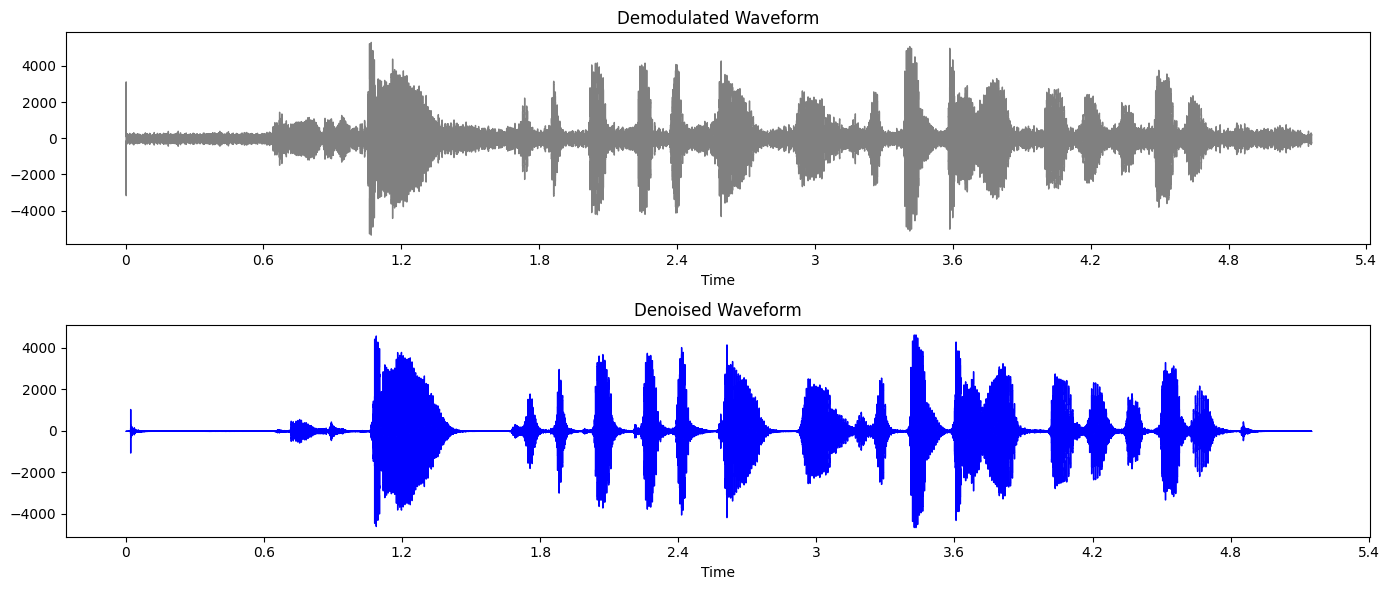

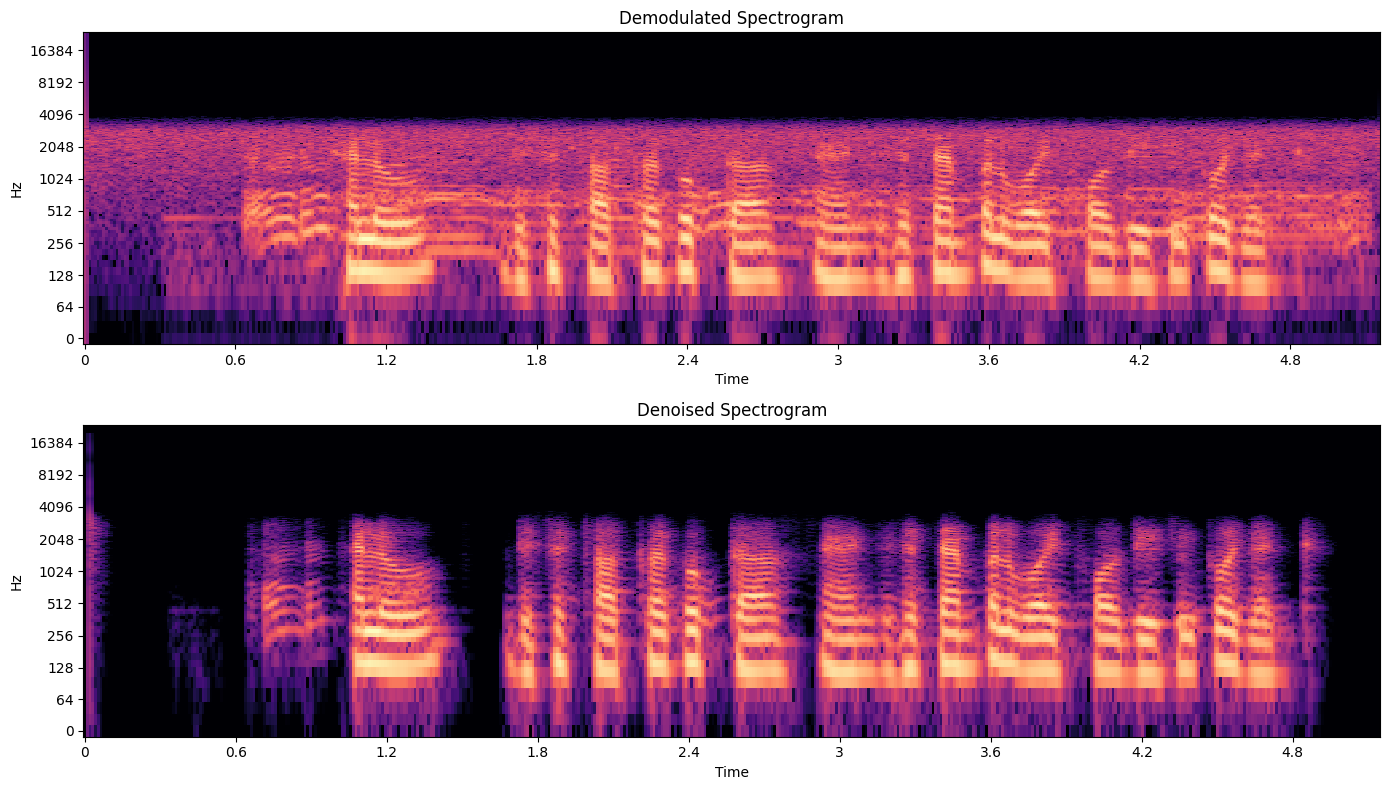

In [26]:
#AUDIO_PATH = "/content/dc2.wav"  # change to your file path
#y, sr = load_audio(AUDIO_PATH)

y= clean_audio
sr= mod_fs
print("\n🎧 Demodulated Audio:")
display(Audio(y, rate=sr))

y_denoised = denoise_rnnoise(y)

print("\n🎙️ Denoised Audio:")
display(Audio(y_denoised, rate=sr))

plot_waveforms(y, y_denoised, sr)
plot_spectrograms(y, y_denoised, sr)

# Speech Recognition (Deep Learning)

In [ ]:
from google.colab import drive  # to upload dataset from google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [26]:
class SpeakerDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_sr=16000, n_mels=64, fixed_frames=256):
        self.samples = []
        self.labels = []
        self.speakers = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.speaker_to_idx = {spk: i for i, spk in enumerate(self.speakers)}
        self.transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=target_sr, n_mels=n_mels
        )
        self.target_sr = target_sr
        self.n_mels = n_mels
        self.fixed_frames = fixed_frames

        for speaker in self.speakers:
            spk_dir = os.path.join(root_dir, speaker)
            for file in os.listdir(spk_dir):
                if file.lower().endswith(".wav"):
                    self.samples.append(os.path.join(spk_dir, file))
                    self.labels.append(self.speaker_to_idx[speaker])

    def __len__(self):
        return len(self.samples)

    def _pad_or_truncate(self, spec):
        _, n_mels, t = spec.shape
        if t > self.fixed_frames:
            spec = spec[:, :, :self.fixed_frames]
        elif t < self.fixed_frames:
            pad = torch.zeros((1, n_mels, self.fixed_frames - t))
            spec = torch.cat([spec, pad], dim=2)
        return spec

    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, self.target_sr)
        # ensure mono
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        spec = self.transform(waveform)  # (1, n_mels, time)
        spec = (spec - spec.mean()) / (spec.std() + 1e-5)
        spec = self._pad_or_truncate(spec)
        return spec, label

root = "/content/dataset"   # change according to your dataset
dataset = SpeakerDataset(root_dir=root, target_sr=16000, n_mels=64, fixed_frames=256)

print(f"Total samples: {len(dataset)}")
print(f"Speakers: {dataset.speakers}")

# Split into train, validation, test (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

Total samples: 600
Speakers: ['speaker_01', 'speaker_02', 'speaker_03', 'speaker_04', 'speaker_05', 'speaker_06', 'speaker_07', 'speaker_08', 'speaker_09', 'speaker_10']
Train: 420, Val: 90, Test: 90


In [31]:
#Model parameters
class SpeakerCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpeakerCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SpeakerCNN(num_classes=len(dataset.speakers)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
#Training with logging
best_val_loss = float('inf')
save_path = "best_speaker_model.pth"

epochs = 100
train_losses, val_losses, val_accs, lrs = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for specs, labels in train_loader:
        specs, labels = specs.to(device), labels.to(device)
        outputs = model(specs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for specs, labels in val_loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total * 100

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Train Loss: {avg_train_loss:.4f} "
          f"- Val Loss: {avg_val_loss:.4f} "
          f"- Val Acc: {val_acc:.2f}%  - LR: {lrs[-1]:.6f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved new best model (val_loss={avg_val_loss:.4f})")

print(f"\nTraining complete! Best model saved at: {save_path}")

# saving with full data
torch.save({
    'model_state_dict': model.state_dict(),
    'speakers': dataset.speakers,
    'speaker_to_idx': dataset.speaker_to_idx,
    'model_class': 'SpeakerCNN',
    'num_classes': len(dataset.speakers)
}, "speaker_cnn_complete.pth")
print("✅ Model saved correctly with metadata!")

# Testing & Evaluation
# Load best model for testing
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

true_labels, pred_labels = [], []

with torch.no_grad():
    for specs, labels in test_loader:
        specs, labels = specs.to(device), labels.to(device)
        outputs = model(specs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

Epoch [1/100] - Train Loss: 2.1748 - Val Loss: 2.1178 - Val Acc: 24.44%  - LR: 0.001000
✅ Saved new best model (val_loss=2.1178)
Epoch [2/100] - Train Loss: 1.9289 - Val Loss: 1.8366 - Val Acc: 37.78%  - LR: 0.001000
✅ Saved new best model (val_loss=1.8366)
Epoch [3/100] - Train Loss: 1.8176 - Val Loss: 1.7079 - Val Acc: 43.33%  - LR: 0.001000
✅ Saved new best model (val_loss=1.7079)
Epoch [4/100] - Train Loss: 1.7108 - Val Loss: 1.6727 - Val Acc: 42.22%  - LR: 0.001000
✅ Saved new best model (val_loss=1.6727)
Epoch [5/100] - Train Loss: 1.6235 - Val Loss: 1.4976 - Val Acc: 40.00%  - LR: 0.001000
✅ Saved new best model (val_loss=1.4976)
Epoch [6/100] - Train Loss: 1.5445 - Val Loss: 1.4745 - Val Acc: 47.78%  - LR: 0.001000
✅ Saved new best model (val_loss=1.4745)
Epoch [7/100] - Train Loss: 1.5404 - Val Loss: 1.4726 - Val Acc: 48.89%  - LR: 0.001000
✅ Saved new best model (val_loss=1.4726)
Epoch [8/100] - Train Loss: 1.4573 - Val Loss: 1.3549 - Val Acc: 53.33%  - LR: 0.001000
✅ Saved n

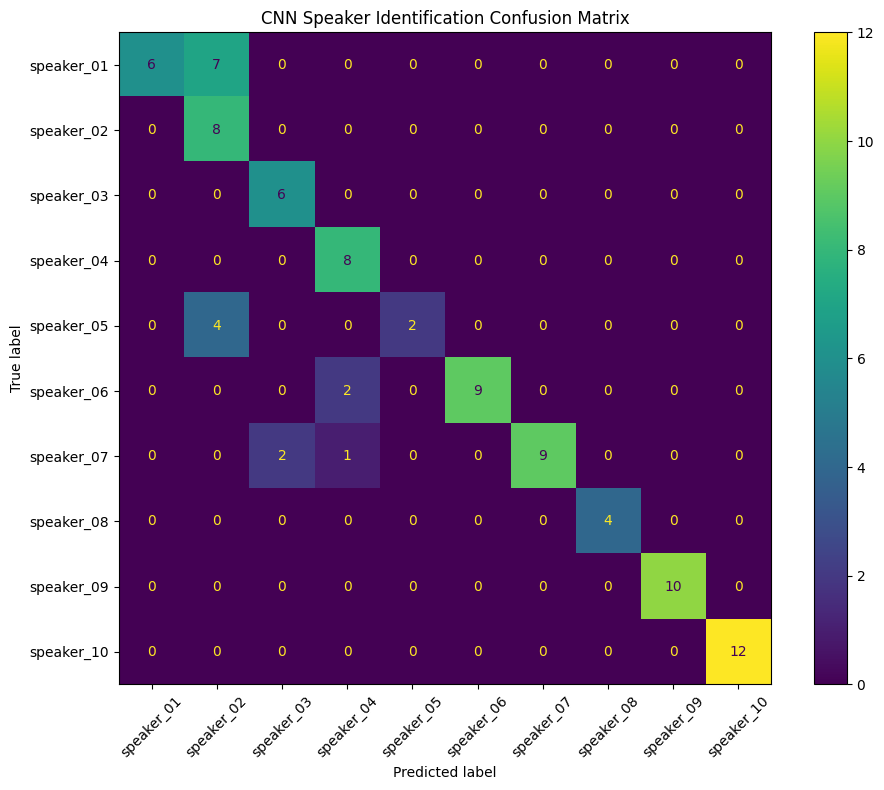


Classification Report:
              precision    recall  f1-score   support

  speaker_01       1.00      0.46      0.63        13
  speaker_02       0.42      1.00      0.59         8
  speaker_03       0.75      1.00      0.86         6
  speaker_04       0.73      1.00      0.84         8
  speaker_05       1.00      0.33      0.50         6
  speaker_06       1.00      0.82      0.90        11
  speaker_07       1.00      0.75      0.86        12
  speaker_08       1.00      1.00      1.00         4
  speaker_09       1.00      1.00      1.00        10
  speaker_10       1.00      1.00      1.00        12

    accuracy                           0.82        90
   macro avg       0.89      0.84      0.82        90
weighted avg       0.91      0.82      0.82        90

Test Accuracy: 82.22%


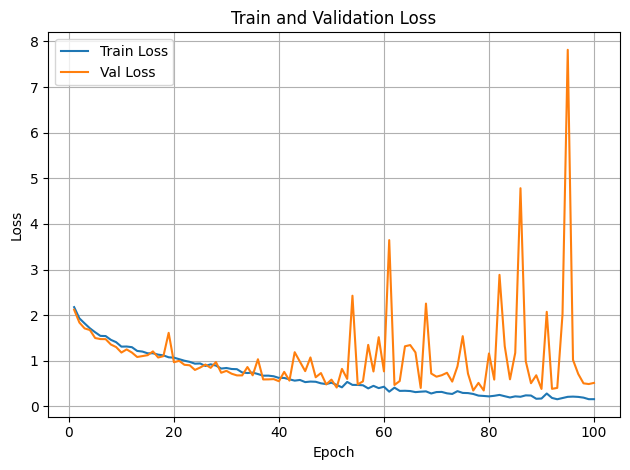

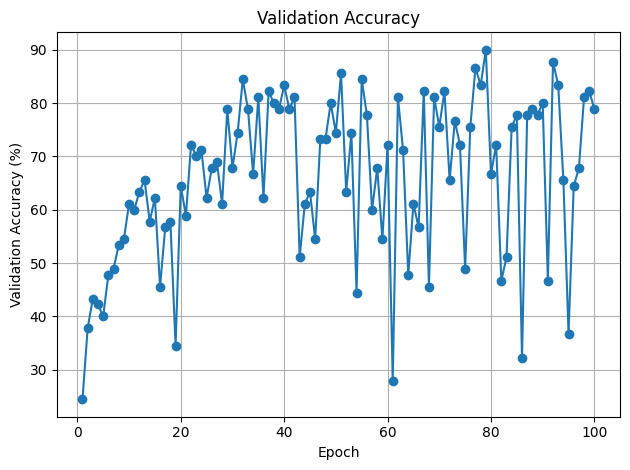

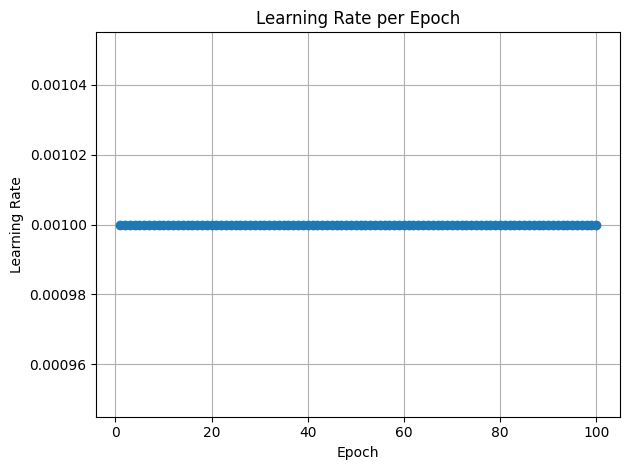

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Plots saved: loss_curve.png, val_accuracy.png, learning_rate.png, all_speakers_mels.png


<Figure size 1200x3000 with 0 Axes>

In [33]:
# Plots
# 1.) Confusion matrix and classification report
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.speakers)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="viridis", xticks_rotation=45)
plt.title("CNN Speaker Identification Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=dataset.speakers, zero_division=0))

acc = np.mean(np.array(true_labels) == np.array(pred_labels))
print(f"Test Accuracy: {acc*100:.2f}%")


# 2.) Train/Val Loss curve
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

# 3.) Validation accuracy curve
plt.figure()
plt.plot(range(1, epochs+1), val_accs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("val_accuracy.png")
plt.show()

# 4.) Learning rate curve (logged each epoch)
plt.figure()
plt.plot(range(1, epochs+1), lrs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate per Epoch")
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_rate.png")
plt.show()

# 5.) Plot example mel spectrograms (not working)
os.makedirs("speaker_mels", exist_ok=True)
plt.figure(figsize=(12, 3 * len(dataset.speakers)))
for spk in dataset.speakers:
    try:
        idx = dataset.labels.index(dataset.speaker_to_idx[spk])
        path = dataset.samples[idx]
    except ValueError:
        path = next((p for p, lab in zip(dataset.samples, dataset.labels)
                     if lab == dataset.speaker_to_idx[spk]), None)

    if path is None:
        continue

    waveform, sr = torchaudio.load(path)
    if sr != dataset.target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, dataset.target_sr)
    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    spec = dataset.transform(waveform)
    spec = (spec - spec.mean()) / (spec.std() + 1e-5)
    spec = dataset._pad_or_truncate(spec)

    spec_np = spec.squeeze().cpu().numpy()  # (n_mels, frames)

    # Individual Figure per Speaker
    plt.figure(figsize=(10, 4))
    plt.imshow(spec_np, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Speaker: {spk} | file: {os.path.basename(path)}")
    plt.xlabel("Frames")
    plt.ylabel("Mel bins")
    plt.colorbar()
    # plt.tight_layout()

    # Save individually
    out_path = f"speaker_mels/{spk}_mel.png"
    plt.savefig(out_path)
    plt.close()

print("Plots saved: loss_curve.png, val_accuracy.png, learning_rate.png, all_speakers_mels.png")

In [ ]:
#prediction function to test your audio files
def predict_speaker_from_checkpoint(model_path, audio_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model_local = SpeakerCNN(num_classes=checkpoint['num_classes']).to(device)
    model_local.load_state_dict(checkpoint['model_state_dict'])
    model_local.eval()
    speakers = checkpoint['speakers']

    waveform, sr = torchaudio.load(audio_path)
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)
    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
    spec = transform(waveform)
    spec = (spec - spec.mean()) / (spec.std() + 1e-5)

    # pad/truncate like in dataset
    if spec.size(2) < 256:
        pad = torch.zeros((1, spec.size(1), 256 - spec.size(2)))
        spec = torch.cat([spec, pad], dim=2)
    else:
        spec = spec[:, :, :256]

    spec = spec.unsqueeze(0).to(device)  # batch
    with torch.no_grad():
        outputs = model_local(spec)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_idx].item()

    # show top 3:
    top_probs, top_indices = torch.topk(probs[0], min(3, len(speakers)))
    print(f"\nTop predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
        print(f"  {i}. {speakers[idx.item()]}: {prob.item()*100:.2f}%")

    return speakers[pred_idx], confidence

In [ ]:
# predict_speaker_from_checkpoint(model_path, audio_path, device) #change audio_path to your test_voice path